# Data analysis: Covid cases over time

Data analysis of daily new covid cases in different countries, using data from:

https://github.com/CSSEGISandData/COVID-19

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [2]:
plt.style.use("ggplot")

## Import and clean up data

### Read the CSV

In [3]:
df = pd.read_csv("time_series_covid19_confirmed_global.csv")

In [4]:
df.head(3)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,156649,156739,156739,156812,156864,156896,156911,157015,157032,157144
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,193856,194472,195021,195523,195988,195988,196611,197167,197776,198292
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,208245,208380,208532,208695,208839,208952,209111,209283,209463,209624


### Remove unused columns

In [5]:
df = df.drop(["Lat", "Long"], axis=1)

In [6]:
df.head(3)

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,156649,156739,156739,156812,156864,156896,156911,157015,157032,157144
1,NaN,Albania,0,0,0,0,0,0,0,0,...,193856,194472,195021,195523,195988,195988,196611,197167,197776,198292
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,208245,208380,208532,208695,208839,208952,209111,209283,209463,209624


### Make the date a column

In [7]:
df = df.melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name="Cases")

In [8]:
df.head(3)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,1/22/20,0
1,NaN,Albania,1/22/20,0
2,NaN,Algeria,1/22/20,0


### Make values in date column proper dates

In [9]:
df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df.dtypes

Province/State            object
Country/Region            object
Date              datetime64[ns]
Cases                      int64
dtype: object

In [11]:
df.head(3)

,Province/State,Country/Region,Date,Cases
0,NaN,Afghanistan,2020-01-22,0
1,NaN,Albania,2020-01-22,0
2,NaN,Algeria,2020-01-22,0


### Sum provinces, aggregate to country level

In [12]:
df[(df["Country/Region"] == "United Kingdom") & (df["Date"] == df["Date"].max())]

,Province/State,Country/Region,Date,Cases
188699,Anguilla,United Kingdom,2021-11-25,1334
188700,Bermuda,United Kingdom,2021-11-25,5730
188701,British Virgin Islands,United Kingdom,2021-11-25,2773
188702,Cayman Islands,United Kingdom,2021-11-25,6459
188703,Channel Islands,United Kingdom,2021-11-25,17116
188704,Falkland Islands (Malvinas),United Kingdom,2021-11-25,79
188705,Gibraltar,United Kingdom,2021-11-25,7092
188706,Isle of Man,United Kingdom,2021-11-25,10895
188707,Montserrat,United Kingdom,2021-11-25,44
188708,"Saint Helena, Ascension and Tristan da Cunha",United Kingdom,2021-11-25,4


In [13]:
df = df.groupby(["Country/Region", "Date"]).sum()

Dataframe is now indexed by country and date and selection can be done via `loc[]`:

In [14]:
df.loc["United Kingdom"].iloc[-1]

Cases    10076116
Name: 2021-11-25 00:00:00, dtype: int64

### Convert cumulative total to daily new cases

In [15]:
df.loc["United Kingdom"].iloc[-5:]

,Cases
Date,
2021-11-21,9897206
2021-11-22,9942859
2021-11-23,9985879
2021-11-24,10028829
2021-11-25,10076116


In [16]:
df = df.groupby(level="Country/Region").diff()

In [17]:
df.loc["United Kingdom"].iloc[-5:]

,Cases
Date,
2021-11-21,39548.0
2021-11-22,45653.0
2021-11-23,43020.0
2021-11-24,42950.0
2021-11-25,47287.0


## Analyze

In [18]:
date_from = pd.to_datetime("2021-01-01")
date_to   = pd.to_datetime("2021-12-31")

countries = sorted([
    "Poland",
    "Czechia",
    "Germany",
    "Austria",
    "United Kingdom"
])

In [19]:
def plot(df):
    fig, ax = plt.subplots(figsize=(16,5))
    df.plot(ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

### Plot cases day by day

In [20]:
cases_day_by_day = df.loc[(countries, slice(date_from, date_to)), "Cases"]
cases_day_by_day.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-01     2096.0
                2021-01-02     1391.0
                2021-01-03     1466.0
                2021-01-04     1642.0
                2021-01-05     2311.0
Czechia         2021-01-01    13361.0
                2021-01-02     3447.0
                2021-01-03     5012.0
                2021-01-04     6233.0
                2021-01-05    12921.0
Germany         2021-01-01    15575.0
                2021-01-02    11036.0
                2021-01-03    10356.0
                2021-01-04    12320.0
                2021-01-05    18349.0
Poland          2021-01-01    10896.0
                2021-01-02     7006.0
                2021-01-03     5782.0
                2021-01-04     4385.0
                2021-01-05     7596.0
United Kingdom  2021-01-01    53458.0
                2021-01-02    57853.0
                2021-01-03    55157.0
                2021-01-04    58923.0
                2021-01-05    61087.0
Name: Cases, dtype: flo

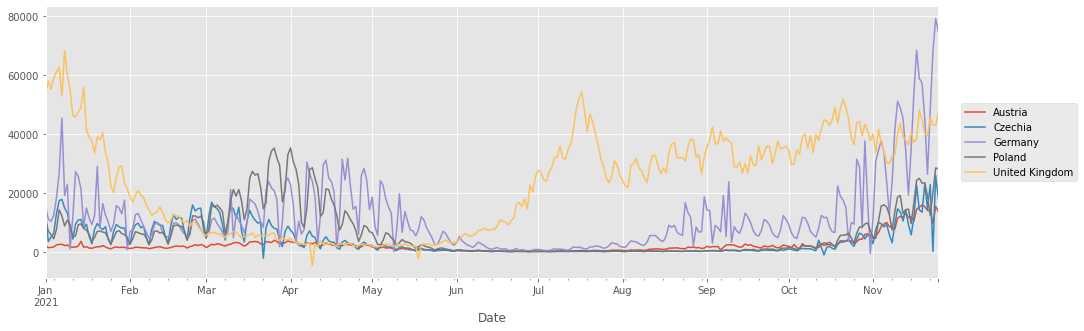

In [21]:
plot(cases_day_by_day.unstack(level="Country/Region"))

### Plot cases week-by-week

In [22]:
def week_start(dt):
    return dt - timedelta(days=dt.weekday())

In [23]:
cases_week_by_week = (
    df.loc[(countries, slice(week_start(date_from), date_to)), "Cases"]
    .groupby(level="Country/Region")
    .resample("1W", level="Date")
    .sum()
)
cases_week_by_week.groupby(level="Country/Region").head()

Country/Region  Date      
Austria         2021-01-03     13876.0
                2021-01-10     14954.0
                2021-01-17     13056.0
                2021-01-24     10936.0
                2021-01-31      9684.0
Czechia         2021-01-03     69882.0
                2021-01-10     90684.0
                2021-01-17     57994.0
                2021-01-24     48458.0
                2021-01-31     47157.0
Germany         2021-01-03    125257.0
                2021-01-10    145514.0
                2021-01-17    120719.0
                2021-01-24     97640.0
                2021-01-31     77890.0
Poland          2021-01-03     60763.0
                2021-01-10     66960.0
                2021-01-17     50060.0
                2021-01-24     39863.0
                2021-01-31     37940.0
United Kingdom  2021-01-03    367471.0
                2021-01-10    418669.0
                2021-01-17    324372.0
                2021-01-24    252117.0
                2021-01-31    170326.

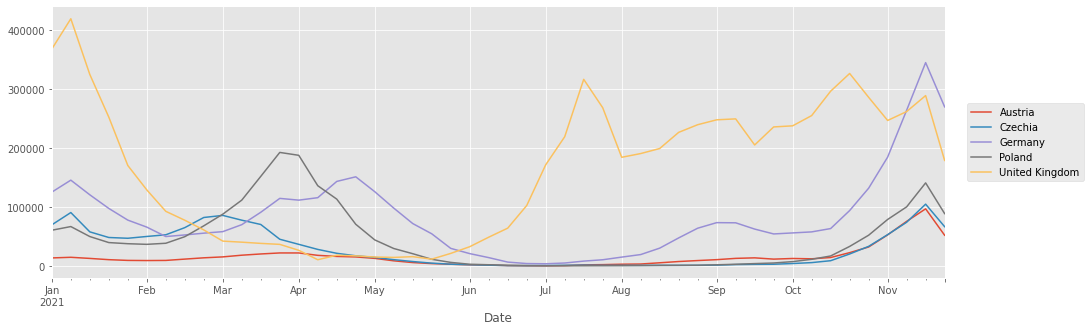

In [24]:
plot(cases_week_by_week.unstack(level="Country/Region"))

### Plot moving average of cases

In [25]:
def moving_average(df, window_days, date_from, date_to):
    return (
        df.loc[(slice(None), slice(date_from - timedelta(days=window_days-1), date_to)), "Cases"]
        .groupby(level="Country/Region")
        .apply(lambda s: s.rolling(7).sum())
        .loc[(countries, slice(date_from, date_to))]
    )

In [26]:
cases_moving_average = moving_average(df.loc[countries], 7, date_from, date_to)
cases_moving_average.groupby(level="Country/Region").head(10)

Country/Region  Date      
Austria         2021-01-01     13856.0
                2021-01-02     13818.0
                2021-01-03     13876.0
                2021-01-04     13926.0
                2021-01-05     14369.0
                2021-01-06     14288.0
                2021-01-07     13915.0
                2021-01-08     13882.0
                2021-01-09     14769.0
                2021-01-10     14954.0
Czechia         2021-01-01     67159.0
                2021-01-02     67900.0
                2021-01-03     69882.0
                2021-01-04     72374.0
                2021-01-05     74433.0
                2021-01-06     75345.0
                2021-01-07     76079.0
                2021-01-08     77579.0
                2021-01-09     87247.0
                2021-01-10     90684.0
Germany         2021-01-01    129768.0
                2021-01-02    127300.0
                2021-01-03    125257.0
                2021-01-04    123573.0
                2021-01-05    122810.

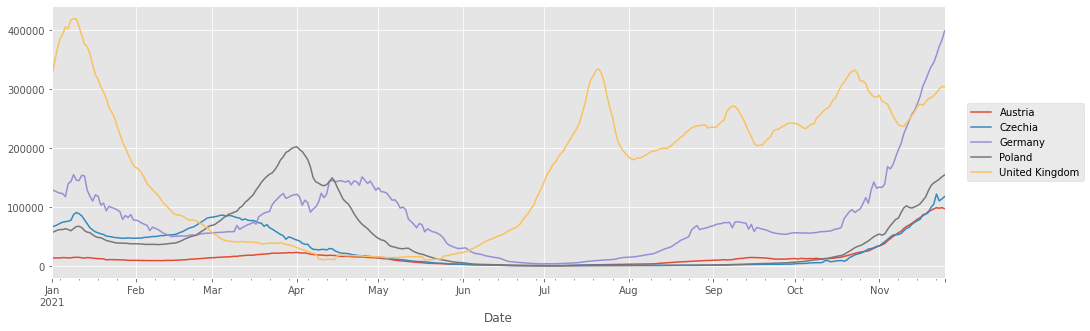

In [27]:
plot(cases_moving_average.unstack(level="Country/Region"))